In [1]:
import sympy as sp

In [2]:
c0 = sp.Symbol("c_0", positive=True)
L = sp.Symbol("L", positive=True)
x = sp.Symbol("x", positive=True)
t = sp.Symbol("t", positive=True)
D = sp.Symbol("D", positive=True)
n = sp.Symbol("n", integer=True, positive=True)

c = sp.Function("c")(x, t)


In [3]:
integral = c0 * L * (1 - sp.sin(sp.pi * n)/(sp.pi * n))

f = 0
c_E_x = c0*(1-x/L)

integral = sp.integrate((f-c_E_x)*sp.sin(n*sp.pi*x/L), (x, 0, L))

Bn = 2/L * integral
infinite_sum = sp.Sum(Bn * sp.sin(n*sp.pi*x/L) * sp.exp(-D*(n*sp.pi/L)**2 * t), (n, 1, sp.oo))

c_expr = c0 * (1 - x/L) + infinite_sum
sp.Eq(c, c_expr)

Eq(c(x, t), c_0*(1 - x/L) + Sum(-2*c_0*exp(-pi**2*D*n**2*t/L**2)*sin(pi*n*x/L)/(pi*n), (n, 1, oo)))

In [4]:
flux_expr = -D*sp.diff(c_expr, x).subs(x, L)
flux_expr.simplify()

D*c_0*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

In [5]:
K_H = sp.Symbol("K_H")
P_up = sp.Symbol("P_\mathrm{up}")
perm = sp.Symbol("\Phi")

flux_expr = flux_expr.subs(c0, K_H * P_up).simplify()
flux_expr = flux_expr.subs(D*K_H, perm).simplify()
flux_expr

P_\mathrm{up}*\Phi*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

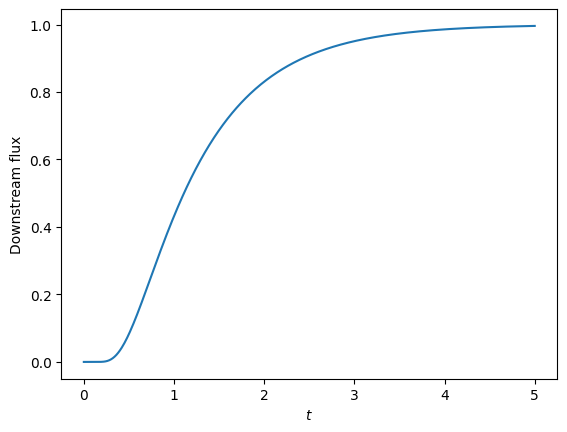

In [6]:
import numpy as np

P_up = 2
perm = 1
D = 0.5
L = 2

t_array = np.linspace(1e-8, 5, num=500)

def downstream_flux(t, P_up, permeability, L, D):
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t_array), axis=0)
    return P_up * permeability / L * (2*summation + 1)

flux = downstream_flux(t, P_up, perm, L, D)
flux[0] = 0

import matplotlib.pyplot as plt
plt.plot(t_array, flux)
plt.xlabel(r"$t$")
plt.ylabel("Downstream flux")
plt.show()

In [7]:
def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow

In [8]:
import h_transport_materials as htm

temperature_range = [760, 970] * htm.ureg.K

flibe_diffusivity = htm.diffusivities.filter(material=htm.FLIBE).mean()
flibe_diffusivity_min = flibe_diffusivity.value(temperature_range[0])
flibe_diffusivity_max = flibe_diffusivity.value(temperature_range[1])
flibe_solubility_min = 1e17 * htm.ureg.particle * htm.ureg.m**-3 * htm.ureg.Pa**-1
flibe_solubility_max = 6.29e20 * htm.ureg.particle * htm.ureg.m**-3 * htm.ureg.Pa**-1

flibe_permeability_max = flibe_solubility_max*flibe_diffusivity_max
flibe_permeability_min = flibe_solubility_min*flibe_diffusivity_min


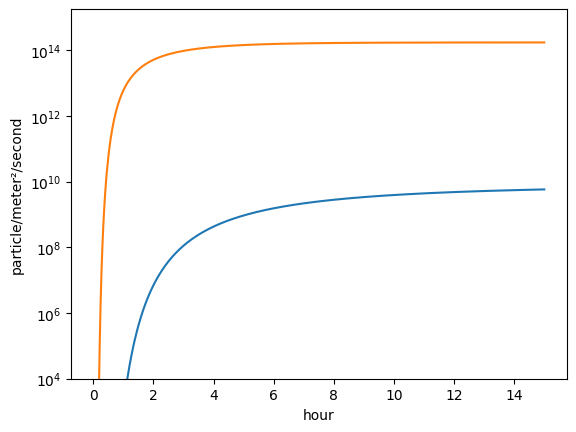

In [9]:
t_array = np.linspace(1e-8, 15, num=500) * htm.ureg.hour
L = 20 * htm.ureg.mm
P_up = 1 * htm.ureg.Pa
radius = 25 * htm.ureg.mm
A = np.pi * radius**2
gas_flow = 20 * htm.ureg.cm**3 * htm.ureg.min**-1

for D, perm in zip([flibe_diffusivity_min, flibe_diffusivity_max], [flibe_permeability_min, flibe_permeability_max]):
    flux = downstream_flux(t, P_up, perm, L, D)
    flux[0] *= 0
    flux = flux.to(htm.ureg.particle * htm.ureg.m**-2 * htm.ureg.s**-1)
    plt.plot(t_array, flux)
plt.yscale("log")
plt.ylim(bottom=1e4)
# plt.xlabel(r"$t$")
# plt.ylabel("Downstream flux")
plt.show()

(100000000.0, 4.596612643269007e+19)

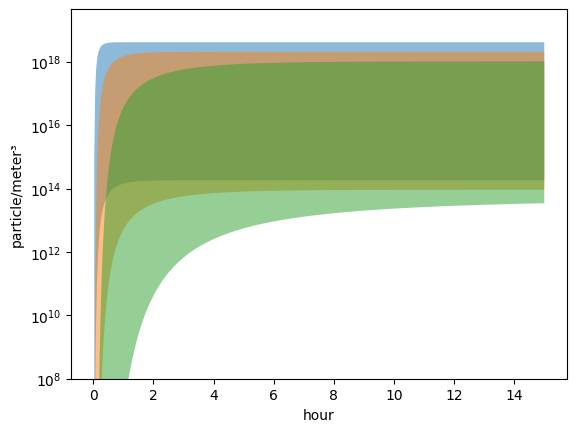

In [12]:
for L in [5, 10, 20] * htm.ureg.mm:
    concentrations = []
    for D, perm in zip([flibe_diffusivity_min, flibe_diffusivity_max], [flibe_permeability_min, flibe_permeability_max]):
        flux = downstream_flux(t, P_up, perm, L, D)
        flux[0] *= 0
        concentrations.append(sweep_gas_concentration(flux, A, gas_flow).to(htm.ureg.particle * htm.ureg.m**-3))
    plt.fill_between(t_array, concentrations[0], concentrations[1], alpha=0.5)

plt.yscale("log")
plt.ylim(bottom=1e8)
